My goal in this project would be to use varios models to analyze Diabities data collected from Kaggle and see what model perform best in predicting the incidence of diabities given some features collected for various patients. I start with a Decision Tree Classifier with the hope that it can give me an intuition on what is the sequence of decisions that leads to each outcome. For this I run the model with several values of some hyperparameters to see which one yields best accuracy for the data at hand.


# Study of Diabities data Set and Creation on ML models to predict the disease

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import GridSearchCV


# Utility Functions
def plotROC(y_test, y_predict, classifier):
  fpr, tpr, thresholds = roc_curve(y_test, y_predict)
  roc_auc = auc(fpr, tpr)
  display = RocCurveDisplay(fpr=fpr, tpr=tpr,roc_auc=roc_auc, estimator_name=classifier)
  display.plot()
  plt.show()

def plotConfusionMatrix(y_test, y_predict, classifier):
  print(f"Confusion Matrix for {classifier}")
  cm = confusion_matrix(y_test, y_predict)
  display = ConfusionMatrixDisplay(cm, display_labels=['positive', 'negative'])
  display.plot()
  plt.show()



df = pd.read_csv('data/diabetes.csv')

print('\nFeatures = ' + str(df.columns[:-1].to_list())) # Show features
print('\nTarget = ' + df.columns[-1])  # Show the outcome

print()
print(df.head())

print()
df.info()


Features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

Target = Outcome

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 

## Data Visualization

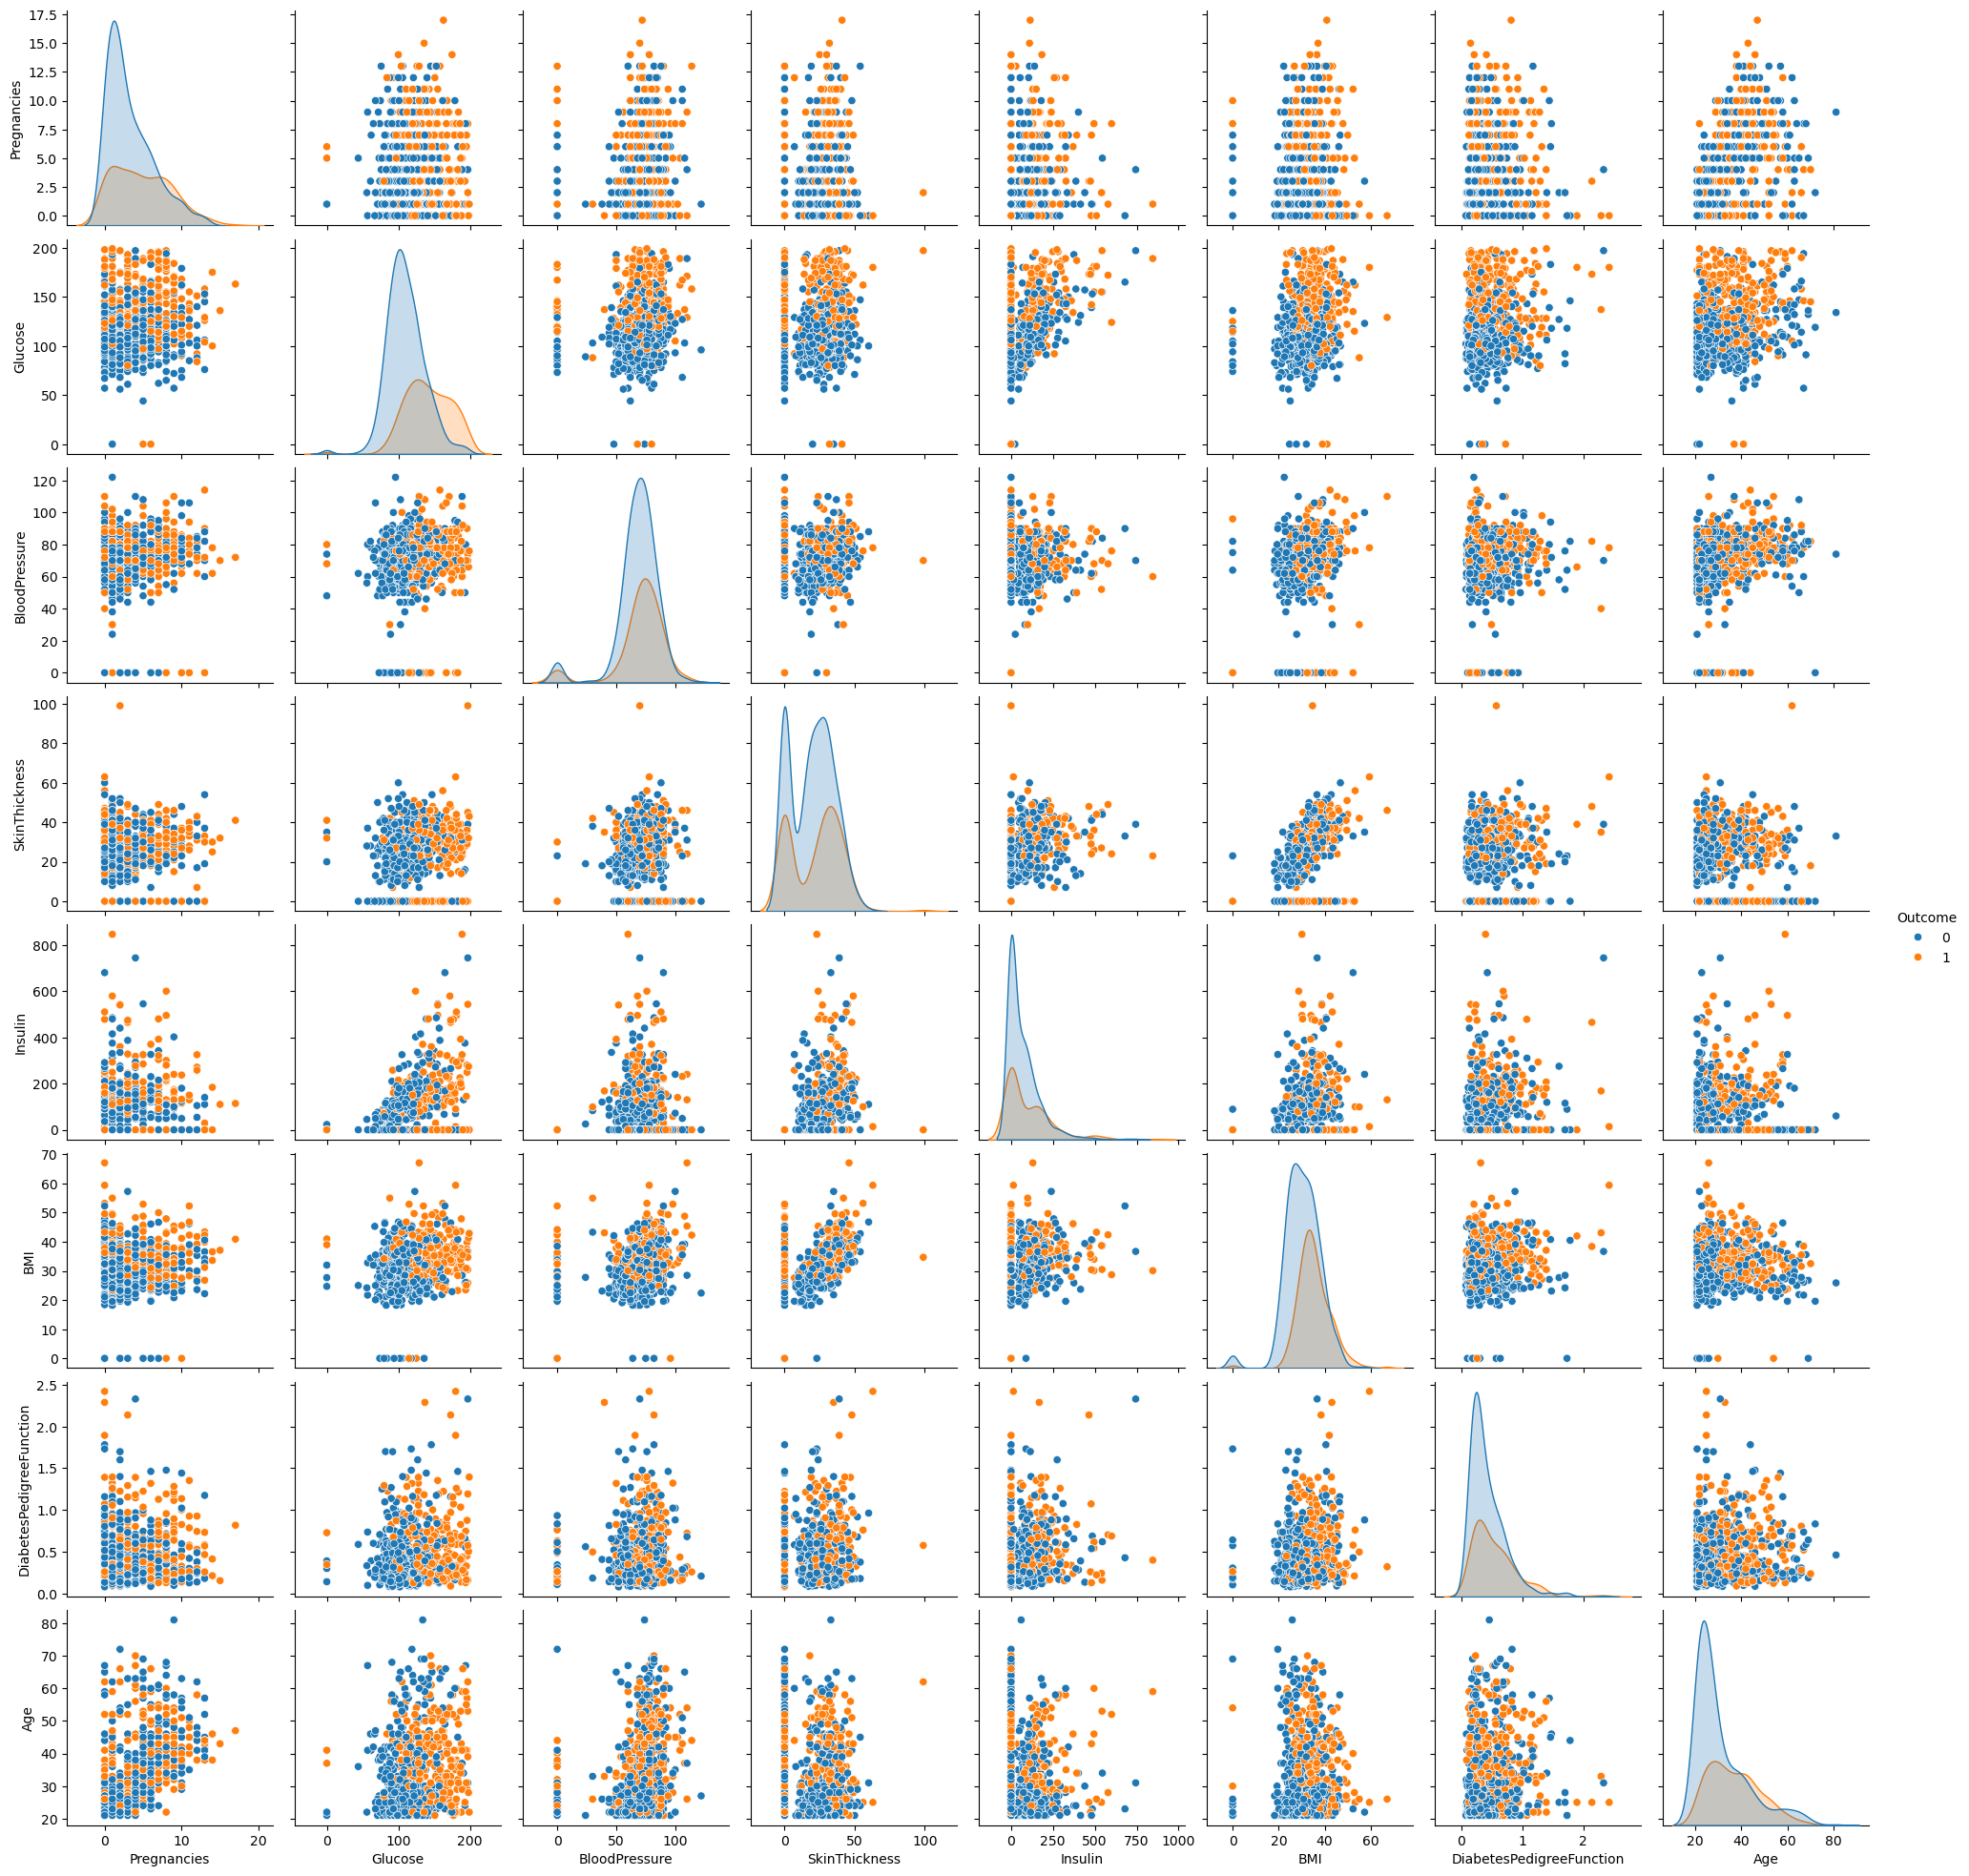

In [6]:
# Create visualization of features and their correlation with target variable
# This plot shows how separable the outcome is based on high impact features like Glucose and BMI
# Note the charts show some outliers in BMI, Bloodpressure, and Glucose that motivates
# Data clean up done later.

sns.pairplot(df, hue='Outcome')
plt.show()


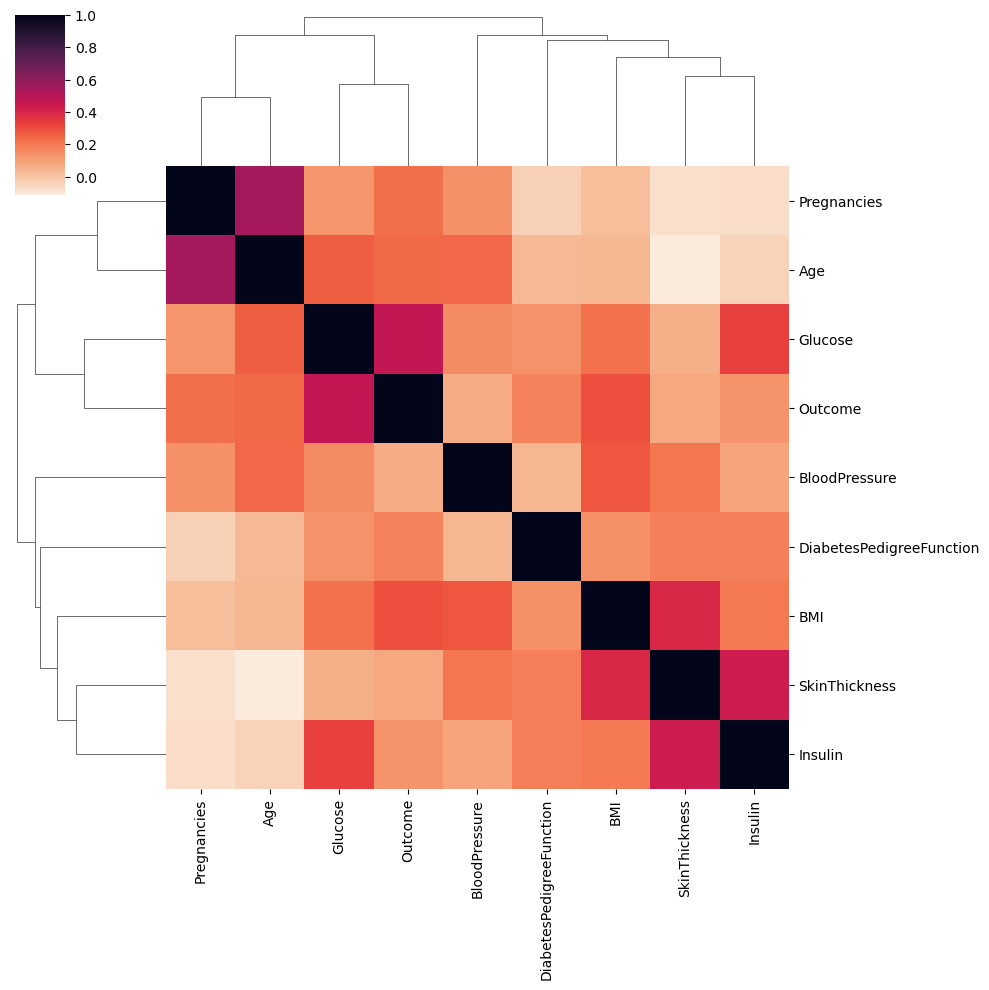

In [8]:
# Display direct correlation impact of each feature on Outcome: highest correlation on Glucose and BMI

sns.clustermap(df.corr(), cmap="rocket_r")
plt.show()

## Data Cleanup

Rows before cleaning: 768


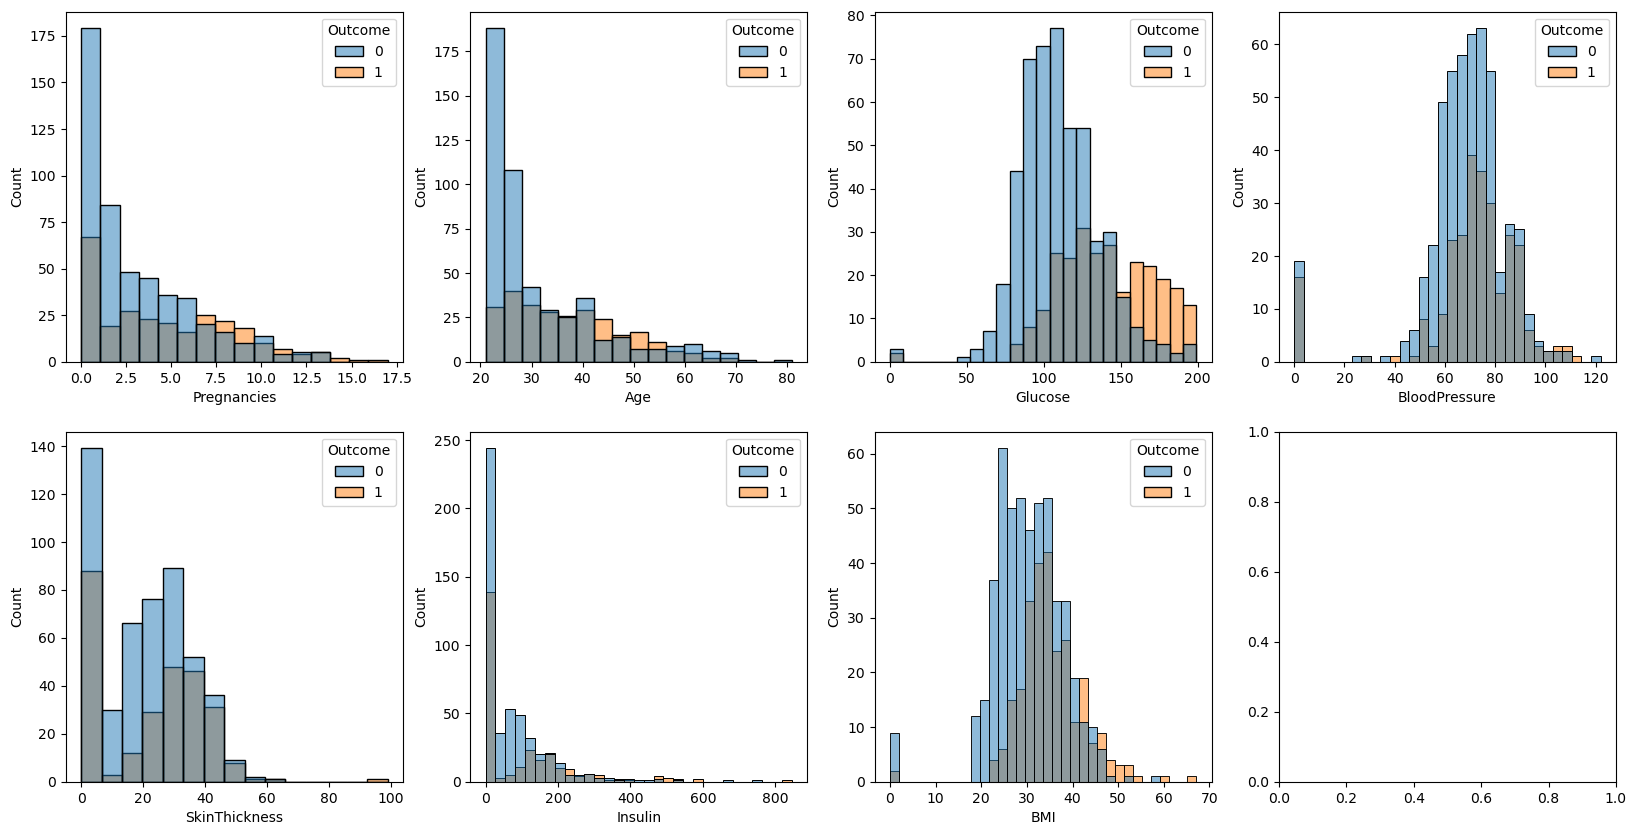

In [12]:
# Data Cleaning plot features histogram to zoom in into outliers
print(f'Rows before cleaning: {len(df)}')

fig, axs = plt.subplots(ncols=4, nrows=2)
fig.set_figheight(10)
fig.set_figwidth(20)
sns.histplot(data=df, x='Pregnancies', hue='Outcome', ax=axs[0][0])
sns.histplot(data=df, x='Age', hue='Outcome', ax=axs[0][1])
sns.histplot(data=df, x='Glucose', hue='Outcome', ax=axs[0][2])
sns.histplot(data=df, x='BloodPressure', hue='Outcome', ax=axs[0][3])
sns.histplot(data=df, x='SkinThickness', hue='Outcome', ax=axs[1][0])
sns.histplot(data=df, x='Insulin', hue='Outcome', ax=axs[1][1])
sns.histplot(data=df, x='BMI', hue='Outcome', ax=axs[1][2])
plt.show()


# Clean up Outliers and Graph again


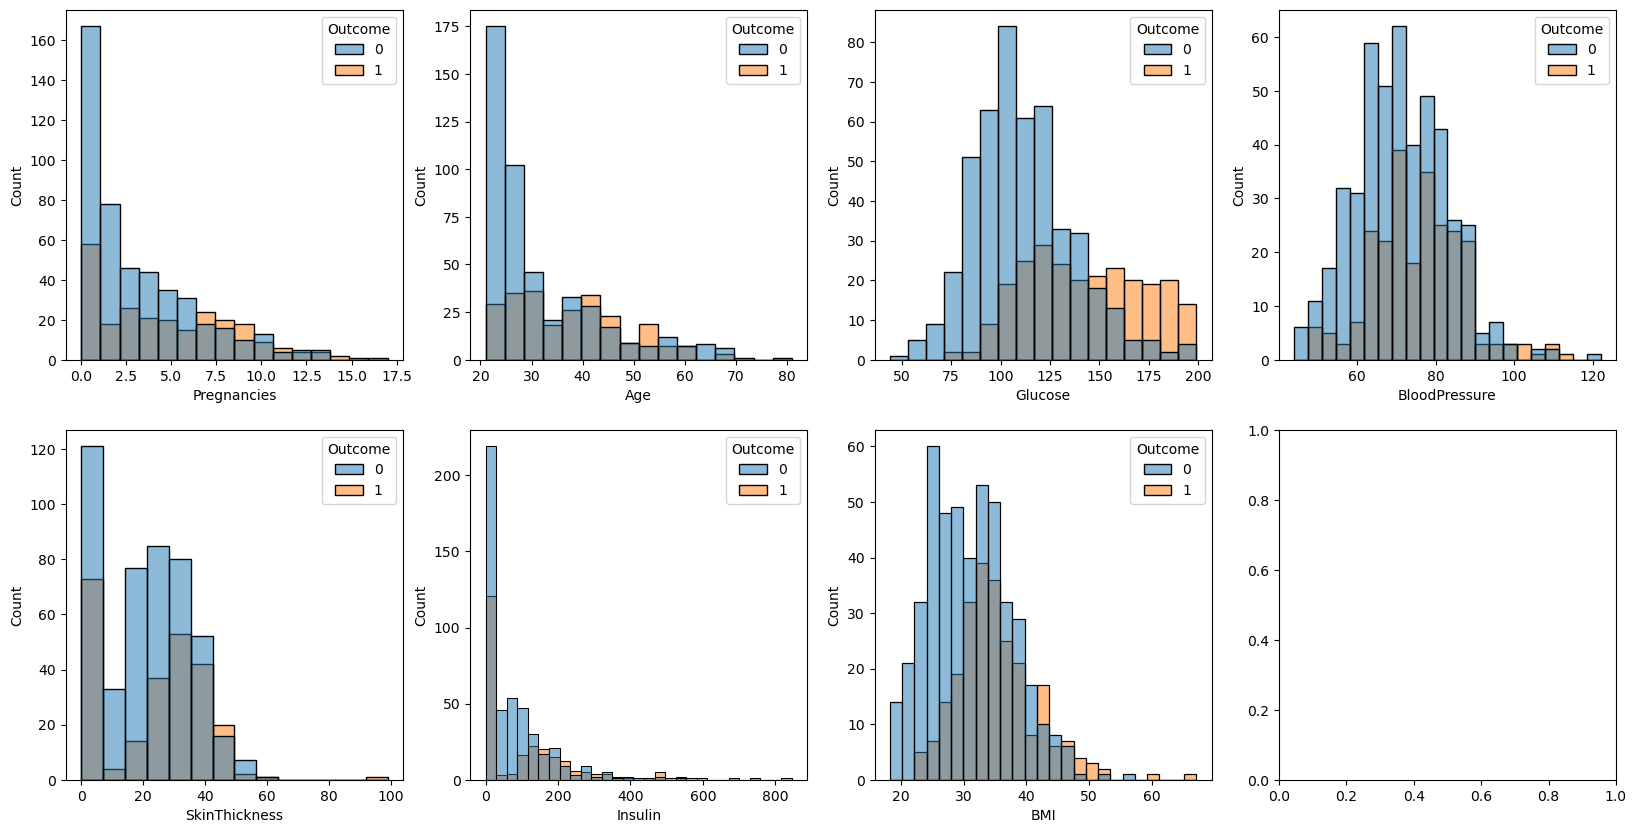

Rows after cleaning: 719


In [15]:
# Clean up entries with Glucose 0 and Blood Pressure 0
df_clean = df[(df['Glucose'] != 0) & (df['BloodPressure'] > 40) & (df['BMI'] > 5)]
fig, axs = plt.subplots(ncols=4, nrows=2)
fig.set_figheight(10)
fig.set_figwidth(20)
sns.histplot(data=df_clean, x='Pregnancies', hue='Outcome', ax=axs[0][0])
sns.histplot(data=df_clean, x='Age', hue='Outcome', ax=axs[0][1])
sns.histplot(data=df_clean, x='Glucose', hue='Outcome', ax=axs[0][2])
sns.histplot(data=df_clean, x='BloodPressure', hue='Outcome', ax=axs[0][3])
sns.histplot(data=df_clean, x='SkinThickness', hue='Outcome', ax=axs[1][0])
sns.histplot(data=df_clean, x='Insulin', hue='Outcome', ax=axs[1][1])
sns.histplot(data=df_clean, x='BMI', hue='Outcome', ax=axs[1][2])
plt.show()
print(f'Rows after cleaning: {len(df_clean)}')

## Is Data-Balanced?

In [18]:
# Determine if data is balanced

X = df_clean.iloc[:,0:-1]
y = df_clean.iloc[:,-1]

balance = 100 * y.value_counts(normalize=True)
print(f'False values % {balance[0]:.2f}')
print(f'True values  % {balance[1]:.2f}')
# Use 70/30% split as the threshold for imbalance data
if max(balance[0], balance[1]) > 70:
  print(f'\nData is imbalanced, balance: False % = {balance[0]:.2f} vs True % = {balance[1]:.2f}')
else:
  print(f'\nData is balanced, balance: False % = {balance[0]:.2f} vs True % = {balance[1]:.2f}')


False values % 65.65
True values  % 34.35

Data is balanced, balance: False % = 65.65 vs True % = 34.35


# Metrics to be Used to evaluate our models

Although in the next few lines of code I have added code to track most common metrics in classification I will mostly foucs on using Recall also know  as True Positive Rate. In disease diagnostic it is very important to know how many positives we get right and see how many psotive cases we mispredicted.

Recall = True Positive Rate = Correctly Classified Postives / All Positives
Recall = TPR = TP /(TP + FN)

The second reason for use of recall is that the data is not fully balanced and hence Accuracy may be biased due to the larger number of rows with negative rows. Hence most likely I will base my Grid Search on recall metric.

A metric of secondary importance is Precision as it factors it False Positives:

Precision = TP / (TP + FP)

So in short my priority is to correctly predict True Positives (Highest Recall) but in second place I want to have higher Precision to minimize false positives.

Ti evaluate my algorithms I have also created functions to display Confusion Matrix and ROC-AUC as they visualize the predicting power of the model.

## Train/Test Split

In [23]:
# Split the data, use startify to ensure balance between test and train sets

# We scale for all classifiers as it improves the outcome of all the non-tree based models
# and does not influence the outome of tree-based models

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=0, test_size=0.20, stratify=y)

# Verify composition of train and test sets
train_balance = 100 * y_train.value_counts(normalize=True)
test_balance = 100 * y_test.value_counts(normalize=True)
print(f'Train Set Balance: False % {train_balance[0]:.2f}; True % {train_balance[1]:.2f}')
print(f'Test  Set Balance: False % {test_balance[0]:.2f}; True % {test_balance[1]:.2f}')

Train Set Balance: False % 65.57; True % 34.43
Test  Set Balance: False % 65.97; True % 34.03


## **First Level Model Exploration**
In this section I explore models performance at a first level to get some idea on how hyperparameters behave.

# A First Look At Decision Trees

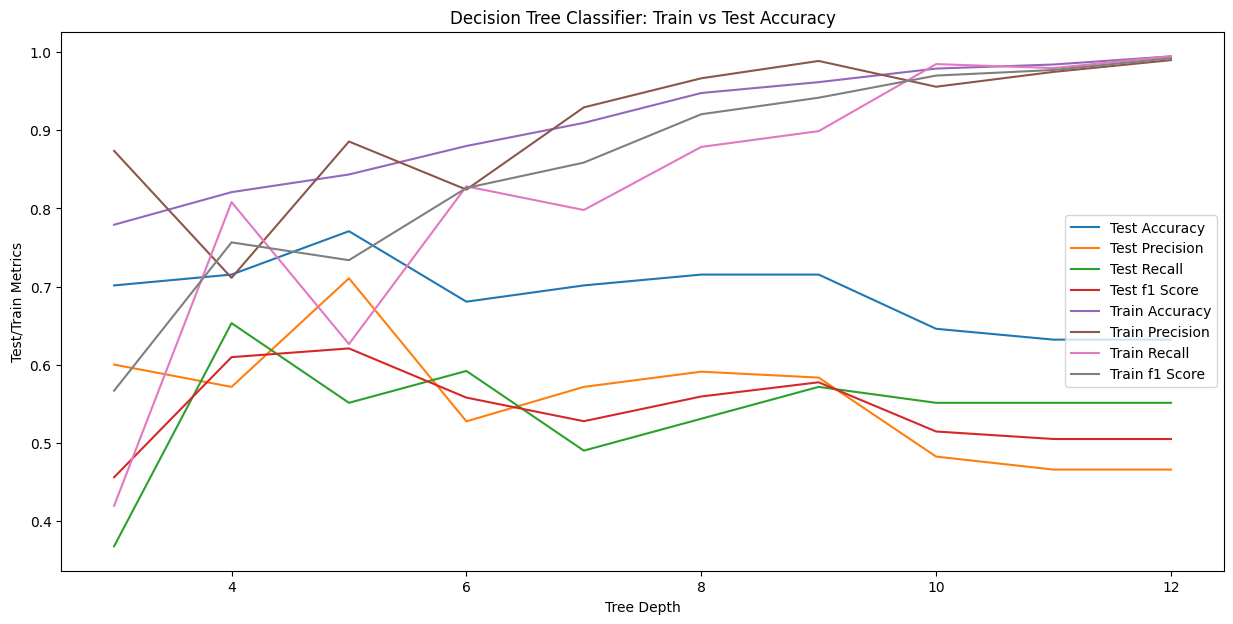

In [115]:

# Initial exploration to get a sense of accuracy and main hyper-parameter
# For the various Algorithms to be evaluated

def get_scores(y, y_predict, scores):
  scores['accuracy'].append(accuracy_score(y, y_predict))
  scores['precision'].append(precision_score(y, y_predict))
  scores['recall'].append(recall_score(y, y_predict))
  scores['f1'].append(f1_score(y, y_predict))

model_test_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}
model_train_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}

models = []
# Use these two dictionaries to store all best metrics for each model
all_best_test_metrics = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}
all_best_train_metrics = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}

best_train_metrics = {
  'accuracy' : 0,
  'precision' : 0,
  'recall' : 0,
  'f1' : 0
}

best_test_metrics = {
  'accuracy' : 0,
  'precision' : 0,
  'recall' : 0,
  'f1' : 0
}
def reset_model_scores(model_test_scores, model_train_scores):
  for key in model_test_scores.keys():
    model_test_scores[key] = []
  for key in model_train_scores.keys():
    model_train_scores[key] = []

def reset_best_metrics(best_test_metrics, best_train_metrics):
  for key in best_train_metrics.keys():
    best_train_metrics[key] = 0
  for key in best_test_metrics.keys():
    best_test_metrics[key] = 0

# Tracks best metrics observed so far based on metric_name for test
# scores. Tracks best hyper parameter
def get_best_metric(metric_name, model_test_scores, model_train_scores,
                    best_test_metrics, best_train_metrics, best_param,
                    current_param):
  if model_test_scores[metric_name][-1] > best_test_metrics[metric_name]:
    for key in best_test_metrics.keys():
      best_test_metrics[key] = model_test_scores[key][-1]
    for key in best_train_metrics.keys():
      best_train_metrics[key] = model_train_scores[key][-1]
    best_param = current_param
  return best_param

def store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics):
  for key in best_test_metrics.keys():
    all_best_test_metrics[key].append(best_test_metrics[key])
  for key in best_train_metrics.keys():
    all_best_train_metrics[key].append(best_train_metrics[key])

preferred_metric_name = 'recall'
best_depth = 0

depth_range = range(3,13)
for depth in depth_range:
  clsf = DecisionTreeClassifier(max_depth=depth, random_state=17)
  clsf.fit(X_train, y_train)
  y_test_predict = clsf.predict(X_test)
  y_train_predict =clsf.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_depth = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_depth, depth)

# Models and metrics are in order so they can be displayed later in dataframe
models.append('decision_tree')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

def plot_scores(hyper_range, model_test_scores, model_train_scores, xlabel, ylabel, title):
  plt.figure(figsize=(15,7),facecolor='white')
  plt.plot(hyper_range, model_test_scores['accuracy'], label='Test Accuracy')
  plt.plot(hyper_range, model_test_scores['precision'], label='Test Precision')
  plt.plot(hyper_range, model_test_scores['recall'], label='Test Recall')
  plt.plot(hyper_range, model_test_scores['f1'], label='Test f1 Score')
  plt.plot(hyper_range, model_train_scores['accuracy'], label='Train Accuracy')
  plt.plot(hyper_range, model_train_scores['precision'], label='Train Precision')
  plt.plot(hyper_range, model_train_scores['recall'], label='Train Recall')
  plt.plot(hyper_range, model_train_scores['f1'], label='Train f1 Score')
  plt.legend()
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

plot_scores(depth_range, model_test_scores, model_train_scores, 'Tree Depth', 'Test/Train Metrics', 'Decision Tree Classifier: Train vs Test Accuracy')


In [116]:
# Summary result of best initial Decision tree classifier


def print_best_metrics(model_name, best_test_metrics, best_train_metrics):
  print(f"\n{model_name} Classifier Test Metrics:")
  for key in best_test_metrics.keys():
    print(f"{key:10}={round(best_test_metrics[key], 3)}")
  print(f"\n{model_name} Classifier Train Metrics:")
  for key in best_train_metrics.keys():
    print(f"{key:10}={round(best_train_metrics[key], 3)}")

print(f"Decision Tree Classifier best_depth = {best_depth}")
print_best_metrics('DecisionTreeClassifier', best_test_metrics, best_train_metrics)



Decision Tree Classifier best_depth = 4

DecisionTreeClassifier Classifier Test Metrics:
accuracy  =0.715
precision =0.571
recall    =0.653
f1        =0.61

DecisionTreeClassifier Classifier Train Metrics:
accuracy  =0.821
precision =0.711
recall    =0.808
f1        =0.757


Confusion Matrix for DecisionTreeClassifier


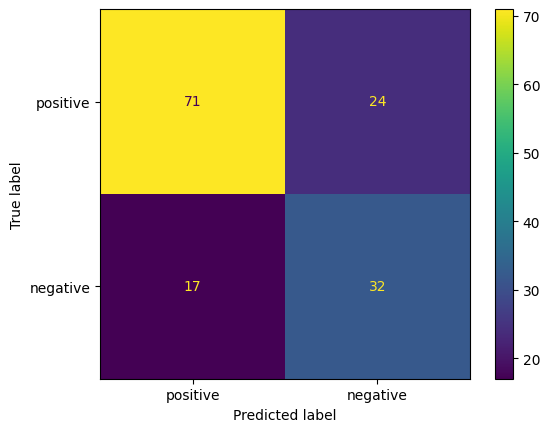

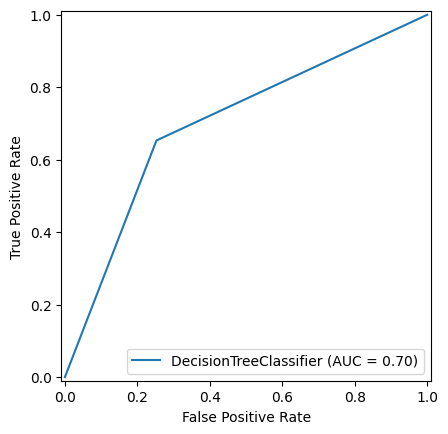

In [117]:
clsf = DecisionTreeClassifier(max_depth=best_depth, random_state=17)
clsf = clsf.fit(X_train, y_train)
y_predict = clsf.predict(X_test)
recall = recall_score(y_test, y_predict)
precision = precision_score(y_test, y_predict)
accuracy = accuracy_score(y_test, y_predict)

plotConfusionMatrix(y_test, y_predict, 'DecisionTreeClassifier')
plotROC(y_test, y_predict, 'DecisionTreeClassifier')

# SVC

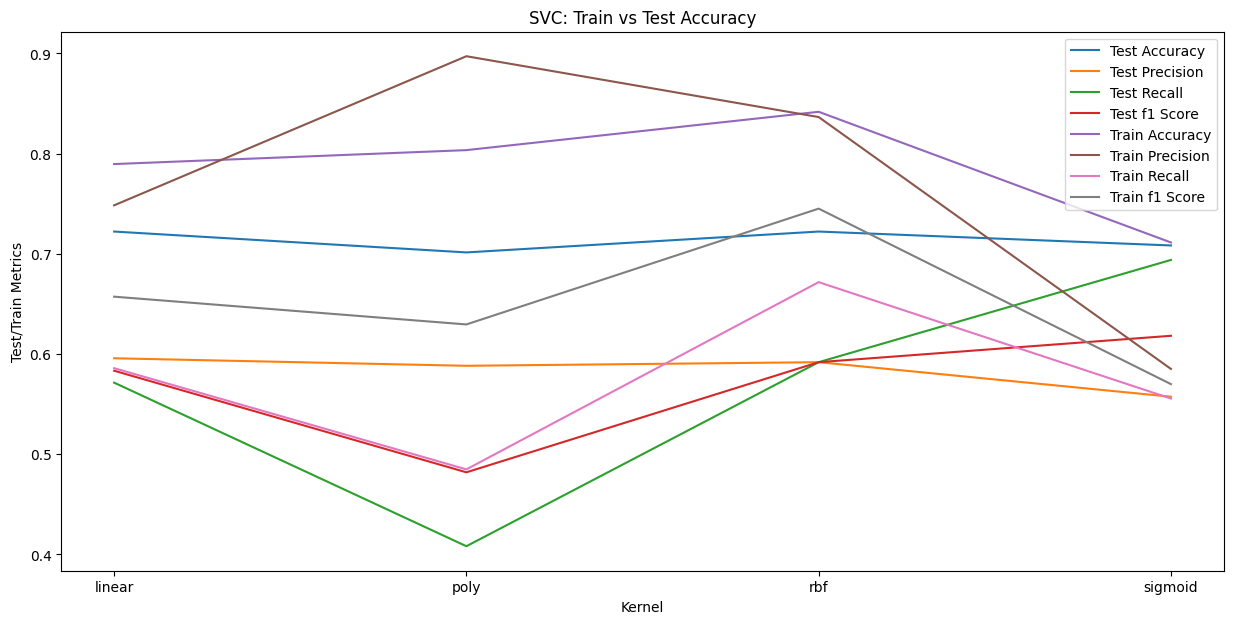

In [118]:
from sklearn.svm import SVC


kernels = ['linear', 'poly', 'rbf', 'sigmoid']

best_kernel = ''

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for kernel in kernels:
  svccls = SVC(kernel=kernel)
  svccls.fit(X_train, y_train)
  y_test_predict = svccls.predict(X_test)
  y_train_predict = svccls.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_kernel = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_kernel, kernel)

models.append('svc')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(kernels, model_test_scores, model_train_scores, 'Kernel', 'Test/Train Metrics', 'SVC: Train vs Test Accuracy')


In [119]:
print(f"SVC Classifier best_kernel = {best_kernel}")
print_best_metrics('SVC Classifier', best_test_metrics, best_train_metrics)


SVC Classifier best_kernel = sigmoid

SVC Classifier Classifier Test Metrics:
accuracy  =0.708
precision =0.557
recall    =0.694
f1        =0.618

SVC Classifier Classifier Train Metrics:
accuracy  =0.711
precision =0.585
recall    =0.556
f1        =0.57


Confusion Matrix for SVCClassifier


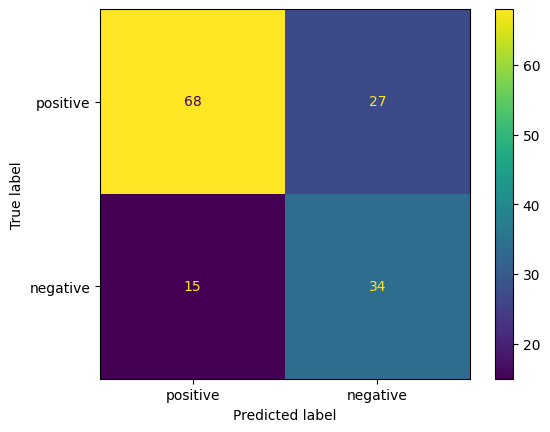

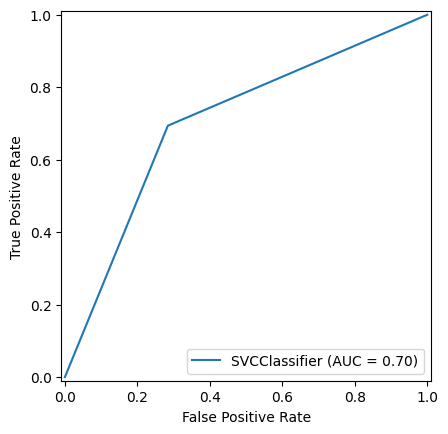

In [120]:

svccls = SVC(kernel=best_kernel)
svccls.fit(X_train, y_train)
y_predict = svccls.predict(X_test)
acuracy = accuracy_score(y_test,y_predict)

plotConfusionMatrix(y_test, y_predict, 'SVCClassifier')
plotROC(y_test, y_predict, 'SVCClassifier')

# Gradient Boosting Classifier

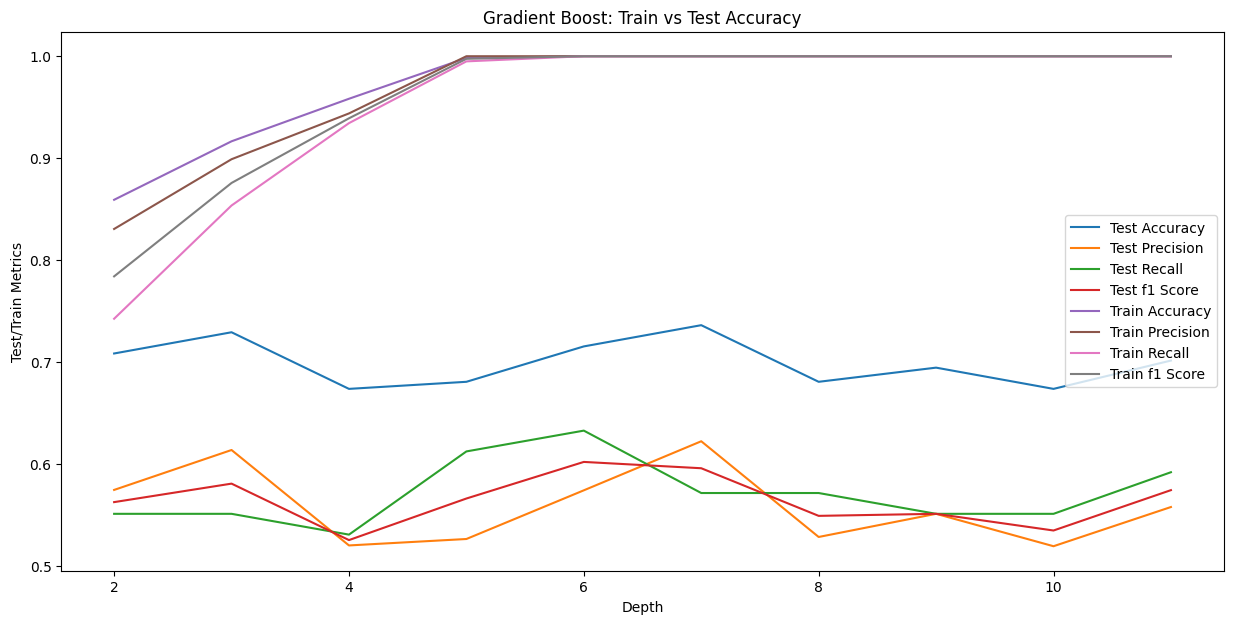

In [121]:
from sklearn.ensemble import GradientBoostingClassifier


best_depth = 0

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for depth in range(2,12):
  for estimators in [10]:
    clsf= GradientBoostingClassifier(n_estimators=estimators, learning_rate=1.0, max_depth=depth, random_state=0)
    clsf.fit(X_train, y_train)

    y_test_predict = clsf.predict(X_test)
    y_train_predict = clsf.predict(X_train)
    get_scores(y_test, y_test_predict, model_test_scores)
    get_scores(y_train, y_train_predict, model_train_scores)
    best_depth = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                                 best_test_metrics, best_train_metrics, best_depth, depth)



models.append('gradient_boost')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(range(2, 12), model_test_scores, model_train_scores, 'Depth', 'Test/Train Metrics', 'Gradient Boost: Train vs Test Accuracy')




In [122]:

print(f"Gradient Boost Classifier best_depth = {best_depth}")
print_best_metrics('DecisionTreeClassifier', best_test_metrics, best_train_metrics)


Gradient Boost Classifier best_depth = 6

DecisionTreeClassifier Classifier Test Metrics:
accuracy  =0.715
precision =0.574
recall    =0.633
f1        =0.602

DecisionTreeClassifier Classifier Train Metrics:
accuracy  =1.0
precision =1.0
recall    =1.0
f1        =1.0


Confusion Matrix for GradientBoostingClassifier


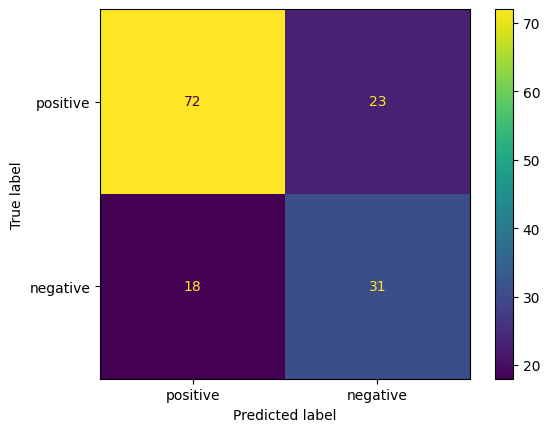

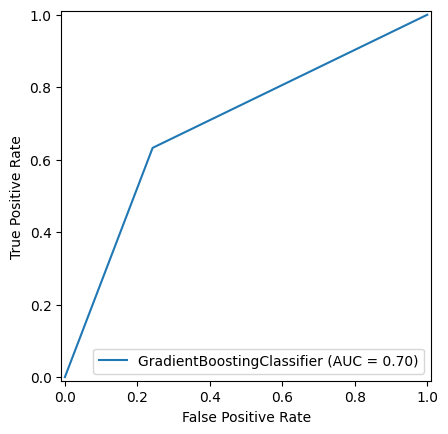

In [123]:
clsf= GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=best_depth, random_state=0)
clsf.fit(X_train, y_train)
y_predict = clsf.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'GradientBoostingClassifier')
plotROC(y_test, y_predict, 'GradientBoostingClassifier')

# Random Forest Classifier

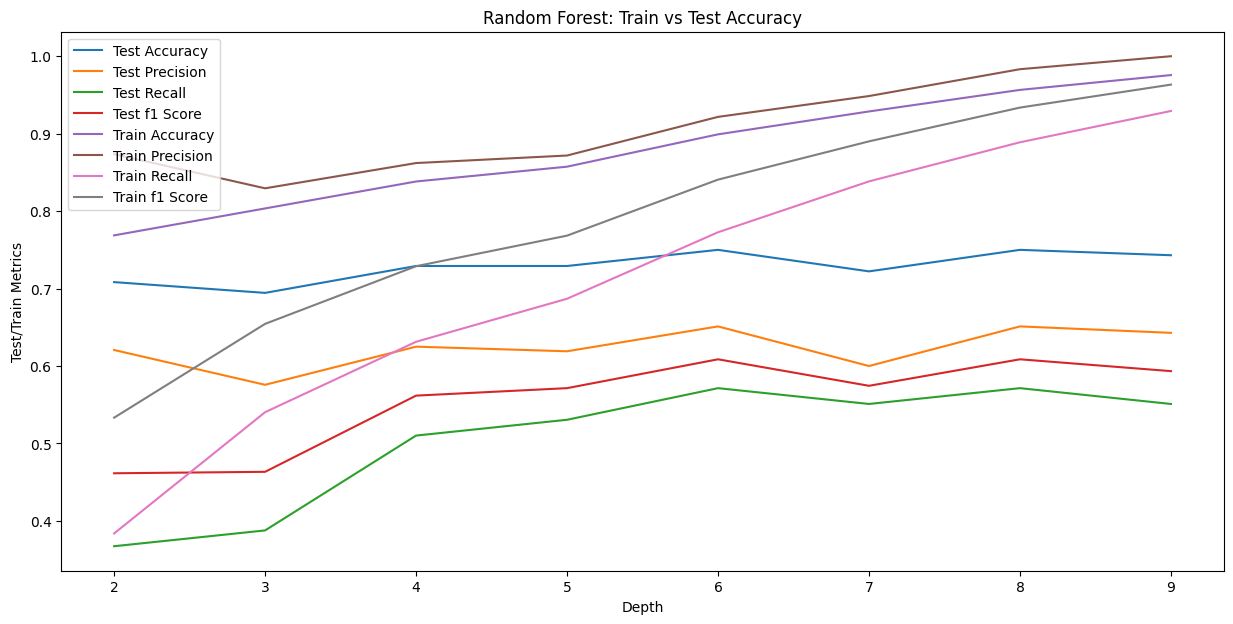

In [124]:
from sklearn.ensemble import RandomForestClassifier

best_depth = 0

model_test_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}
model_train_scores = {
  'accuracy' : [],
  'precision' : [],
  'recall' : [],
  'f1' : []
}

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for depth in range(2, 10):
  rndfc = RandomForestClassifier(max_depth=depth, criterion='entropy', random_state=0)
  rndfc.fit(X_train, y_train)

  y_test_predict = rndfc.predict(X_test)
  y_train_predict = rndfc.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_depth = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_depth, depth)


models.append('random_forest')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(range(2, 10), model_test_scores, model_train_scores, 'Depth', 'Test/Train Metrics', 'Random Forest: Train vs Test Accuracy')


In [125]:
print(f"Random Forest Classifier best_depth = {best_depth}")
print_best_metrics('RandomForestClassifier', best_test_metrics, best_train_metrics)

Random Forest Classifier best_depth = 6

RandomForestClassifier Classifier Test Metrics:
accuracy  =0.75
precision =0.651
recall    =0.571
f1        =0.609

RandomForestClassifier Classifier Train Metrics:
accuracy  =0.899
precision =0.922
recall    =0.773
f1        =0.841


Confusion Matrix for RandomForestClassifier


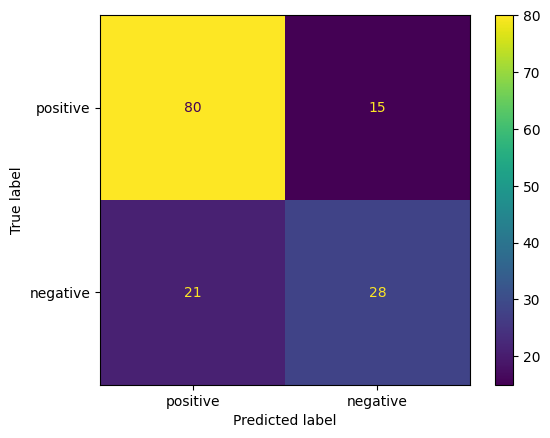

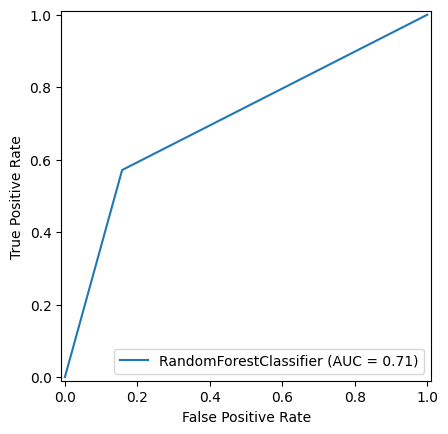

In [126]:
rndfc = RandomForestClassifier(max_depth=best_depth, criterion='entropy', random_state=0)
rndfc.fit(X_train, y_train)
y_predict = rndfc.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'RandomForestClassifier')
plotROC(y_test, y_predict, 'RandomForestClassifier')

# Logistic Regression

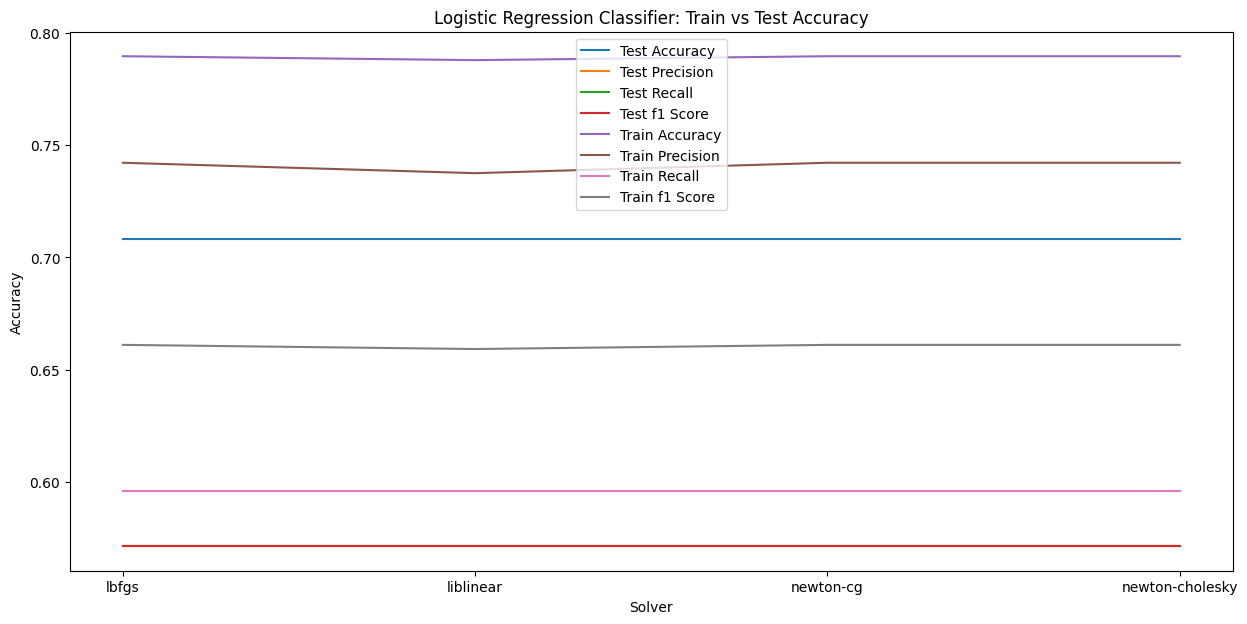

In [127]:
from sklearn import linear_model

best_solver = ''

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky']
for solver in solvers:
  lgst = linear_model.LogisticRegression(max_iter=500, solver=solver);
  lgst.fit(X_train, y_train)

  y_test_predict = lgst.predict(X_test)
  y_train_predict = lgst.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_solver = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                               best_test_metrics, best_train_metrics, best_solver, solver)

models.append('logistic_regression')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(solvers, model_test_scores, model_train_scores, 'Solver', 'Accuracy', 'Logistic Regression Classifier: Train vs Test Accuracy')



In [128]:


print(f"Logistic Regression Classifier best_solver = {best_solver}")
print_best_metrics('LogisticRegressionClassifier', best_test_metrics, best_train_metrics)

Logistic Regression Classifier best_solver = lbfgs

LogisticRegressionClassifier Classifier Test Metrics:
accuracy  =0.708
precision =0.571
recall    =0.571
f1        =0.571

LogisticRegressionClassifier Classifier Train Metrics:
accuracy  =0.79
precision =0.742
recall    =0.596
f1        =0.661


Confusion Matrix for LogisticRegressionClassifier


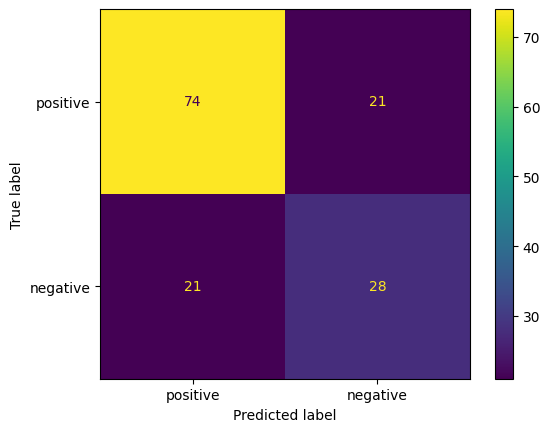

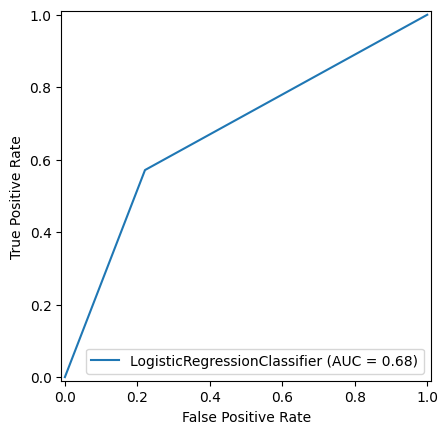

In [129]:
lgst = linear_model.LogisticRegression(max_iter=500, solver=best_solver);
lgst.fit(X_train, y_train)
y_predict = lgst.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'LogisticRegressionClassifier')
plotROC(y_test, y_predict, 'LogisticRegressionClassifier')

# KNN Classifier

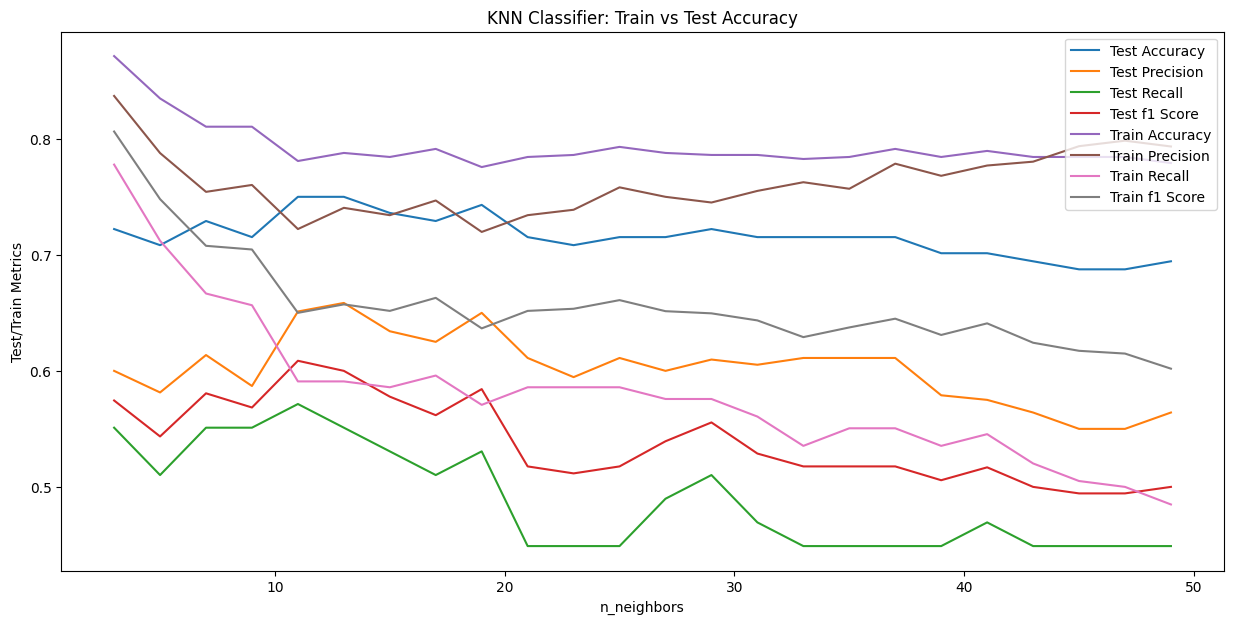

In [130]:
from sklearn.neighbors import KNeighborsClassifier

best_k = 0

reset_model_scores(model_test_scores, model_train_scores)
reset_best_metrics(best_test_metrics, best_train_metrics)

for k in range(3,50,2):
  knn = KNeighborsClassifier(n_neighbors=k)
  knn.fit(X_train, y_train)
  y_test_predict = knn.predict(X_test)
  y_train_predict = knn.predict(X_train)
  get_scores(y_test, y_test_predict, model_test_scores)
  get_scores(y_train, y_train_predict, model_train_scores)
  best_k = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                           best_test_metrics, best_train_metrics, best_k, k)

models.append('knn')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(range(3,50,2), model_test_scores, model_train_scores, 'n_neighbors', 'Test/Train Metrics', 'KNN Classifier: Train vs Test Accuracy')


In [131]:

print(f"KNN Classifier best_k = {best_k}")
print_best_metrics('KNeighborsClassifier', best_test_metrics, best_train_metrics)

KNN Classifier best_k = 11

KNeighborsClassifier Classifier Test Metrics:
accuracy  =0.75
precision =0.651
recall    =0.571
f1        =0.609

KNeighborsClassifier Classifier Train Metrics:
accuracy  =0.781
precision =0.722
recall    =0.591
f1        =0.65


Confusion Matrix for KNNClassifier


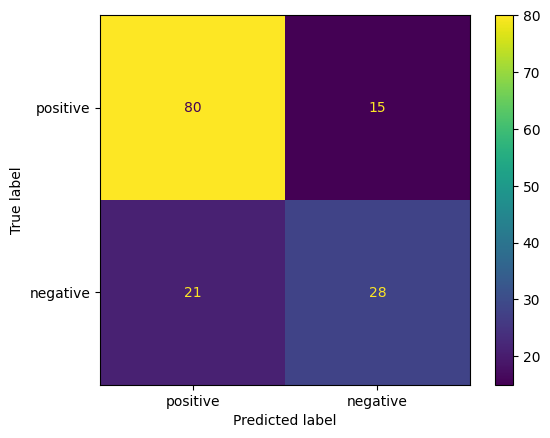

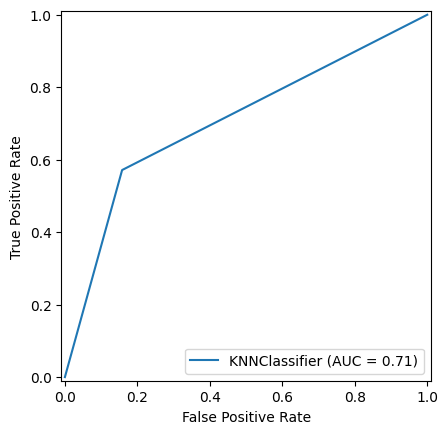

In [132]:
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'KNNClassifier')
plotROC(y_test, y_predict, 'KNNClassifier')

# MLP Classifier

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (600) reached and the optimization hasn't converged yet.
  warnings.warn(


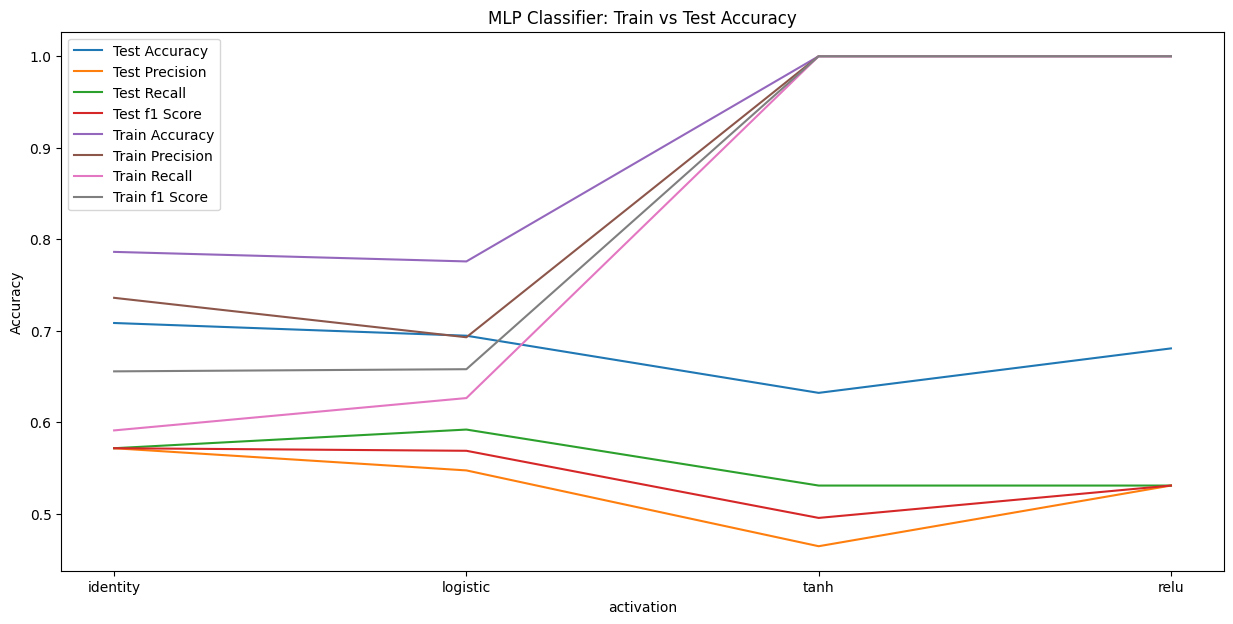

In [133]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

reset_best_metrics(best_test_metrics, best_train_metrics)
reset_model_scores(model_test_scores, model_train_scores)


activations = ['identity', 'logistic', 'tanh', 'relu']
best_activation = ''

for solver in ['adam']:
  for activation in activations:
    for layers in [50]:
      for iters in [600]:
        clsf = MLPClassifier(solver=solver, activation=activation, alpha=1e-4, hidden_layer_sizes=(50,layers, 50), random_state=1, max_iter=iters)
        clsf.fit(X_train, y_train)
        y_test_predict = clsf.predict(X_test)
        y_train_predict = clsf.predict(X_train)
        get_scores(y_test, y_test_predict, model_test_scores)
        get_scores(y_train, y_train_predict, model_train_scores)
        best_activation = get_best_metric(preferred_metric_name, model_test_scores, model_train_scores,
                                          best_test_metrics, best_train_metrics, best_activation, activation)

models.append('mlp')
store_best_metrics(all_best_test_metrics, all_best_train_metrics, best_test_metrics, best_train_metrics)

plot_scores(activations, model_test_scores, model_train_scores, 'activation', 'Accuracy', 'MLP Classifier: Train vs Test Accuracy')




In [134]:

print(f"MLP Classifier best_activation = {best_activation}")
print_best_metrics('MLPClassifier', best_test_metrics, best_train_metrics)


MLP Classifier best_activation = logistic

MLPClassifier Classifier Test Metrics:
accuracy  =0.694
precision =0.547
recall    =0.592
f1        =0.569

MLPClassifier Classifier Train Metrics:
accuracy  =0.776
precision =0.693
recall    =0.626
f1        =0.658


Confusion Matrix for MLPClassifier


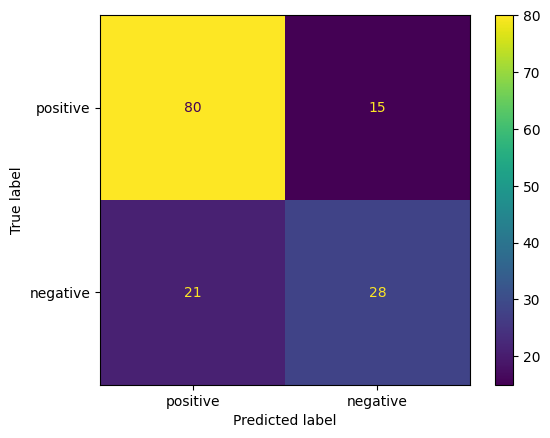

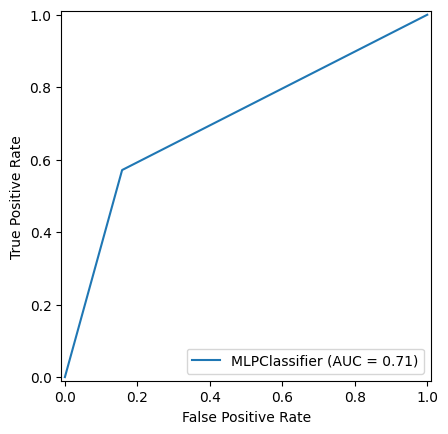

In [135]:
clsf = MLPClassifier(solver='adam', activation=best_activation, alpha=1e-4, hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=600)
clsf.fit(X_train, y_train)
bc_predict_y_test = clsf.predict(X_test)

plotConfusionMatrix(y_test, y_predict, 'MLPClassifier')
plotROC(y_test, y_predict, 'MLPClassifier')

In [136]:

df_results = pd.DataFrame({'model': models, 'test_recall': all_best_test_metrics['recall'], 'train_recall': all_best_train_metrics['recall'],  'test_precision': all_best_test_metrics['precision'], 'train_precision': all_best_train_metrics['precision'], 'test_f1': all_best_test_metrics['f1'], 'train_f1': all_best_train_metrics['f1'], 'test_accuracy': all_best_test_metrics['accuracy'], 'train_accuracy': all_best_train_metrics['accuracy']})
df_results.sort_values(by='test_recall', ascending=False, inplace=True)
df_results

['decision_tree', 'svc', 'gradient_boost', 'random_forest', 'logistic_regression', 'knn', 'mlp']


,model,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1,test_accuracy,train_accuracy
1,svc,0.693878,0.555556,0.557377,0.585106,0.618182,0.569948,0.708333,0.711304
0,decision_tree,0.653061,0.808081,0.571429,0.711111,0.609524,0.756501,0.715278,0.820870
2,gradient_boost,0.632653,1.000000,0.574074,1.000000,0.601942,1.000000,0.715278,1.000000
6,mlp,0.591837,0.626263,0.547170,0.692737,0.568627,0.657825,0.694444,0.775652
3,random_forest,0.571429,0.772727,0.651163,0.921687,0.608696,0.840659,0.750000,0.899130
4,logistic_regression,0.571429,0.595960,0.571429,0.742138,0.571429,0.661064,0.708333,0.789565
5,knn,0.571429,0.590909,0.651163,0.722222,0.608696,0.650000,0.750000,0.780870


# Summary of Base-line results (No significant hyperparameter search)